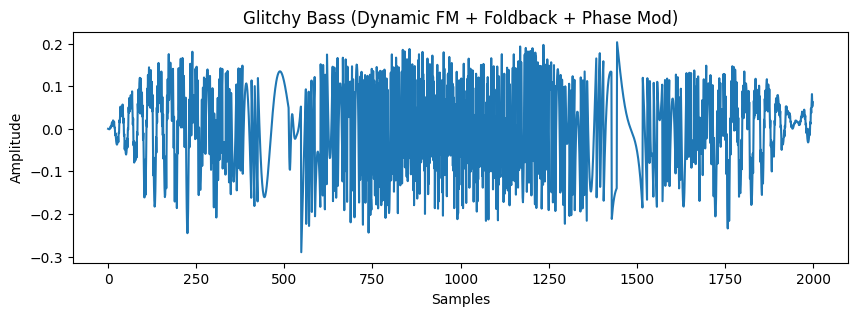

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi, iirfilter
from IPython.display import Audio, display

# Settings/Setup
sr = 44100
duration = 4.0
t = np.linspace(0, duration, int(sr * duration), endpoint=False)
f_base = 11.25

# 3 oscillators, base, detuned up, detuned down
detune = 0.8
osc1 = np.sin(2*np.pi*f_base*t)
osc2 = np.sin(2*np.pi*f_base * 2**(detune/12) * t)
osc3 = np.sin(2*np.pi*f_base * 2**(-detune/12) * t)

# Randomization for the LFOs
lfo_fm_rate = np.random.uniform(0.2, 2.0)      # Rate: 0.2-2 Hz
lfo_fm_phase = np.random.uniform(0, 2*np.pi)   # Random starting phase
lfo_filter_rate = np.random.uniform(0.3, 3.0)  # Rate: 0.3-3 Hz
lfo_filter_phase = np.random.uniform(0, 2*np.pi)
lfo_drive_rate = np.random.uniform(0.5, 2.5)
lfo_drive_phase = np.random.uniform(0, 2*np.pi)

# LFOs
lfo_fm = (np.sin(2*np.pi*lfo_fm_rate*t + lfo_fm_phase) + 1) / 2
lfo_filter = (np.sin(2*np.pi*lfo_filter_rate*t + lfo_filter_phase) + 1) / 2
lfo_drive = (np.sin(2*np.pi*lfo_drive_rate*t + lfo_drive_phase) + 1) / 2

# Dynamic FM tear (frequency modulation)
mod_index = 80 * (0.5 + 0.5*lfo_fm)
fm = np.sin(2*np.pi*(f_base*2)*t)
osc_fm = np.sin(2*np.pi*f_base*t + mod_index*fm)
osc = (osc1 + osc2 + osc3 + osc_fm) / 4.0

# Moving lowpass filter
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = min(0.99, cutoff / nyq)
    b, a = butter(order, normal_cutoff, btype="low")
    return b, a

# autofilter (time/lfo modulation) range: 400hz to 4200khz
cutoff_env = 400 + 4200*lfo_filter
filtered = np.zeros_like(osc)
zi = None
blocksize = 512
for i in range(0, len(t), blocksize):
    cutoff = cutoff_env[i]
    b, a = butter_lowpass(cutoff, sr, order=4)
    chunk = osc[i:i+blocksize]
    if zi is None:
        zi = lfilter_zi(b, a) * chunk[0]
    y, zi = lfilter(b, a, chunk, zi=zi)
    filtered[i:i+blocksize] = y

# Aggressive asymmetric distortion. base + fold back
drive = 3.0 + 4.0*lfo_drive
dist = np.tanh(drive * filtered)
fold = np.mod(filtered * drive * 2.5, 2.0) - 1.0
distorted = 0.7*dist + 0.3*fold

# Stereo phase modulation
phase_offset = np.linspace(0, np.pi/3, len(t))
left = np.tanh(np.sin(2*np.pi*f_base*t + phase_offset) * distorted)
right = np.tanh(np.sin(2*np.pi*f_base*t - phase_offset) * distorted)
stereo = np.vstack([left, right])

# Emphasize midrange: post high-pass EQ
b, a = iirfilter(2, 150/(sr/2), btype='highpass', ftype='butter')
left_hp  = lfilter(b, a, stereo[0])
right_hp = lfilter(b, a, stereo[1])

# Stereo array. 0 = left channel, 1 = right channel
out = np.vstack([left_hp, right_hp])

# Normalize audio to 1 to -1 (prevent clipping)
out /= np.max(np.abs(out))

# Diagram + playback
plt.figure(figsize=(10,3))
plt.plot(out[0, :2000])
plt.title("Glitchy Bass (Dynamic FM + Foldback + Phase Mod)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

display(Audio(out, rate=sr))
